In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [29]:
df=pd.read_excel("nba_2026_all_players_average_per_game.xlsx",index_col=0)

In [30]:
df["Def_activity"] = (df["STL"] + df["BLK"])

In [ ]:
df_top = df.sort_values("MP", ascending=False).head(200)

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PlayerId,Def_activity
0,Luka Doncic,26,LAL,PG,45,45,35.6,10.3,22.1,0.468,...,7.0,7.8,8.6,1.4,0.5,4.1,2.5,32.5,doncilu01,1.9
1,Shai Gilgeous-Alexander,27,OKC,PG,49,49,33.3,10.9,19.7,0.554,...,3.9,4.4,6.4,1.3,0.8,2.1,2.1,31.8,gilgesh01,2.1
2,Anthony Edwards,24,MIN,SG,49,49,35.6,10.2,20.7,0.493,...,4.6,5.3,3.7,1.4,0.8,2.8,1.8,29.6,edwaran01,2.2
3,Jaylen Brown,29,BOS,SF,52,52,34.3,10.8,22.5,0.479,...,6.0,7.1,4.8,1.0,0.4,3.6,2.8,29.1,brownja02,1.4
4,Tyrese Maxey,25,PHI,PG,56,56,38.4,10.1,21.7,0.467,...,3.8,4.1,6.7,2.0,0.8,2.5,2.3,29.1,maxeyty01,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Bilal Coulibaly,21,WAS,SG,37,37,26.2,3.4,8.3,0.406,...,3.5,4.4,2.6,1.5,1.0,1.5,2.5,10.1,coulibi01,2.5
196,Maxime Raynaud,22,SAC,C,52,34,24.0,4.3,7.8,0.550,...,5.1,7.0,1.2,0.5,0.5,1.0,2.3,10.1,raynama01,1.0
197,Christian Braun,24,DEN,SG,23,23,30.4,3.8,7.7,0.494,...,3.0,4.5,2.9,0.7,0.3,1.2,2.3,10.0,braunch01,1.0
198,Royce O'Neale,32,PHO,SF,59,54,29.4,3.5,8.4,0.415,...,4.1,4.9,2.8,1.2,0.3,1.5,2.3,10.0,onealro01,1.5


In [40]:
style_cols = ["AST","3P","2P","TRB","Def_activity","FGA"]
X_scaled = StandardScaler().fit_transform(df_top[style_cols])

In [41]:
kmeans = KMeans(n_clusters=5, random_state=42)
df_top["Cluster"] = kmeans.fit_predict(X_scaled)

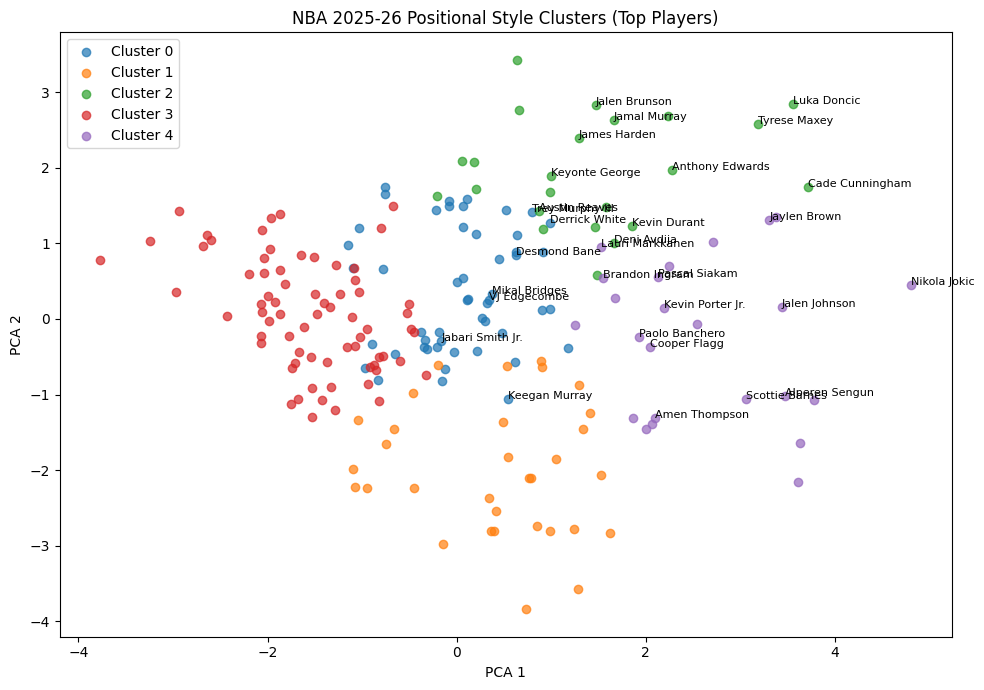

In [ ]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

df_top["x"] = coords[:, 0]
df_top["y"] = coords[:, 1]


plt.figure(figsize=(10, 7))

for c in sorted(df_top["Cluster"].unique()):
    temp = df_top[df_top["Cluster"] == c]
    plt.scatter(temp["x"], temp["y"], label=f"Cluster {c}", alpha=0.7)

plt.title("NBA 2025-26 Positional Style Clusters (Top Players)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()

label_df = df_top.sort_values("MP", ascending=False).head(30)
for _, row in label_df.iterrows():
    plt.text(row["x"], row["y"], row["Player"], fontsize=8)

plt.tight_layout()
plt.show()

In [43]:
out_cols = [
    "Player", "Pos", "Age", "Team", "G", "MP", "PTS", "3P", "2P", "FGA", "TRB", "AST", "STL", "BLK",
    "Def_activity", "Cluster"
]

df_top[out_cols].to_excel("Cluster.xlsx", index=False)

In [44]:
cluster_stats = df_top.groupby("Cluster")[["PTS","AST","TRB","STL","BLK","MP","3P","2P","Def_activity","FGA"]].mean().round(2)
print(cluster_stats)

           PTS   AST   TRB   STL   BLK     MP    3P    2P  Def_activity    FGA
Cluster                                                                       
0        16.56  3.54  4.67  1.18  0.64  29.92  2.13  3.78          1.82  12.97
1        13.40  2.70  8.34  0.92  0.88  27.83  0.64  4.55          1.79   9.58
2        23.68  6.62  4.63  1.10  0.39  33.02  2.63  5.35          1.49  17.30
3        12.62  2.57  3.78  0.74  0.30  25.78  1.82  2.65          1.04   9.81
4        22.80  5.00  7.72  1.18  0.91  32.80  1.32  7.05          2.09  16.52


In [45]:
for c in sorted(df_top["Cluster"].unique()):
    print(f"\nCluster {c} example players:")
    print(df_top[df_top["Cluster"] == c].sort_values("MP", ascending=False).head(5)[["Player","PTS","AST","TRB","MP"]])


Cluster 0 example players:
               Player   PTS  AST  TRB    MP
26    Trey Murphy III  22.1  3.8  5.7  35.6
92       VJ Edgecombe  15.3  4.0  5.5  35.3
90   Jabari Smith Jr.  15.5  1.8  6.9  34.9
111     Keegan Murray  14.0  1.7  5.7  34.5
76      Derrick White  17.1  5.7  4.5  34.3

Cluster 1 example players:
                 Player   PTS  AST   TRB    MP
166       Dyson Daniels  11.3  6.1   6.6  33.4
169         Rudy Gobert  11.2  1.7  11.4  31.4
42   Karl-Anthony Towns  20.0  2.9  11.7  31.3
58          Bam Adebayo  18.3  2.9   9.8  31.2
41         Jimmy Butler  20.0  4.9   5.6  31.1

Cluster 2 example players:
             Player   PTS  AST  TRB    MP
4      Tyrese Maxey  29.1  6.7  4.1  38.4
13     Kevin Durant  25.8  4.6  5.4  36.5
0       Luka Doncic  32.5  8.6  7.8  35.6
2   Anthony Edwards  29.6  3.7  5.3  35.6
19     James Harden  24.5  8.1  4.8  35.0

Cluster 3 example players:
                 Player   PTS  AST  TRB    MP
130      Toumani Camara  13.0  2.6  5.3  33.

In [46]:
df = pd.read_excel("Cluster.xlsx")

STYLE_COLS = ["AST", "3P", "2P", "TRB", "Def_activity", "FGA"]

# Make sure all style cols are numeric
for col in STYLE_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[STYLE_COLS])

# Store scaled values in z_ columns (optional but convenient)
for i, col in enumerate(STYLE_COLS):
    df[f"z_{col}"] = X_scaled[:, i]


def find_similar_players(df, player_name, top_n=5, same_cluster_only=False):
    """
    Find players with the most similar statistical style to `player_name`.

    Similarity is based on standardized (z-scored):
    AST, 3P, 2P, TRB, Def_activity, FGA
    """

    # locate the player row (case-insensitive)
    mask = df["Player"].str.lower() == player_name.lower()
    if not mask.any():
        raise ValueError(f"Player '{player_name}' not found in dataframe.")

    idx = df[mask].index[0]
    player_row = df.loc[idx]

    # style vector for this player (scaled)
    z_cols = [f"z_{c}" for c in STYLE_COLS]
    player_vec = player_row[z_cols].values.astype(float)

    # matrix of all players' style vectors
    all_vecs = df[z_cols].values.astype(float)

    # Euclidean distance to every other player
    dists = np.linalg.norm(all_vecs - player_vec, axis=1)

    df_temp = df.copy()
    df_temp["distance"] = dists

    # optionally restrict to players in the same cluster
    if "Cluster" in df.columns and same_cluster_only:
        same_cluster = player_row["Cluster"]
        df_temp = df_temp[df_temp["Cluster"] == same_cluster]

    # exclude the player themself
    df_temp = df_temp[df_temp.index != idx]

    # sort by distance (smallest = most similar)
    df_temp = df_temp.sort_values("distance").head(top_n)

    # nice columns to show
    cols_show = [
        "Player", "Pos", "Tm", "PTS", "AST", "TRB", "STL", "BLK",
        "MP", "Cluster", "distance"
    ]
    cols_show = [c for c in cols_show if c in df_temp.columns]

    return df_temp[cols_show]


print(find_similar_players(df, "Kon Knueppel"))
print(find_similar_players(df, "Victor Wembanyama"))
print(find_similar_players(df, "James Harden"))

               Player Pos   PTS  AST  TRB  STL  BLK    MP  Cluster  distance
57         Coby White  SG  18.3  4.7  3.7  0.7  0.1  28.6        3  1.488740
73   Payton Pritchard  PG  17.2  5.4  4.2  0.8  0.1  32.7        2  1.549532
103     Devin Vassell  SG  14.4  2.4  3.8  0.8  0.4  30.6        3  1.602655
53        CJ McCollum  PG  18.6  3.5  3.4  0.8  0.4  30.0        0  1.604984
130    Toumani Camara  PF  13.0  2.6  5.3  1.0  0.4  33.4        3  1.708684
             Player Pos   PTS  AST   TRB  STL  BLK    MP  Cluster  distance
38    Anthony Davis  PF  20.4  2.8  11.1  1.1  1.7  31.3        4  2.514803
75        Alex Sarr   C  17.2  2.8   7.8  0.8  2.0  28.2        4  2.581359
51   Scottie Barnes  PF  19.1  5.6   8.2  1.4  1.6  34.3        4  2.632924
66      Evan Mobley  PF  17.5  3.9   8.6  0.9  1.8  32.7        4  2.639390
101  Walker Kessler   C  14.4  3.0  10.8  1.4  1.8  30.8        1  3.155398
               Player Pos   PTS  AST  TRB  STL  BLK    MP  Cluster  distance
47   